# Identify AR Events Gridded

In [1]:
%matplotlib ipympl

In [2]:
import ARUtils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature 

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54159,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:54175,Total threads: 3
Dashboard: http://127.0.0.1:54178/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:54162,


Load data from 1980 - 1989

In [4]:
ds_full = xr.open_dataset('ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1980010100-1989123100.nc')

In [5]:
ds_full

<xarray.Dataset> Size: 3GB
Dimensions:              (lat: 192, lon: 288, lev: 32, ilev: 33, cosp_prs: 7,
                          nbnd: 2, cosp_tau: 7, cosp_scol: 10, cosp_ht: 40,
                          cosp_sr: 15, cosp_sza: 5, cosp_dbze: 15,
                          cosp_htmisr: 16, cosp_tau_modis: 7, cosp_reffice: 6,
                          cosp_reffliq: 6, time: 14600)
Coordinates: (12/16)
  * lat                  (lat) float64 2kB -90.0 -89.06 -88.12 ... 89.06 90.0
  * lon                  (lon) float64 2kB 0.0 1.25 2.5 ... 356.2 357.5 358.8
  * lev                  (lev) float64 256B 3.643 7.595 14.36 ... 976.3 992.6
  * ilev                 (ilev) float64 264B 2.255 5.032 10.16 ... 985.1 1e+03
  * cosp_prs             (cosp_prs) float64 56B 9e+04 7.4e+04 ... 2.45e+04 9e+03
  * cosp_tau             (cosp_tau) float64 56B 0.15 0.8 2.45 ... 41.5 100.0
    ...                   ...
  * cosp_dbze            (cosp_dbze) float64 120B -72.5 -42.5 ... 17.5 50.0
  * cosp_htmisr          (cosp_htmisr) float64 128B 0.0 250.0 ... 1.8e+04
  * cosp_tau_modis       (cosp_tau_modis) float64 56B 0.15 0.8 ... 41.5 100.0
  * cosp_reffice         (cosp_reffice) float64 48B 5e-06 1.5e-05 ... 7.5e-05
  * cosp_reffliq         (cosp_reffliq) float64 48B 4e-06 9e-06 ... 2.5e-05
  * time                 (time) object 117kB 1980-01-01 00:00:00 ... 1989-12-...
Dimensions without coordinates: nbnd
Data variables: (12/35)
    gw                   (lat) float64 2kB ...
    hyam                 (lev) float64 256B ...
    hybm                 (lev) float64 256B ...
    P0                   float64 8B ...
    hyai                 (ilev) float64 264B ...
    hybi                 (ilev) float64 264B ...
    ...                   ...
    n2ovmr               (time) float64 117kB ...
    f11vmr               (time) float64 117kB ...
    f12vmr               (time) float64 117kB ...
    sol_tsi              (time) float64 117kB ...
    nsteph               (time) int32 58kB ...
    IVT                  (time, lat, lon) float32 3GB ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BHISTsmbb.f09_g17.LE2-1111.006
    logname:           sunseon
    host:              mom2
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1111-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_6

Select a set of grid cells that cover Bodega Bay, CA (38.3332° N, 123.0481° W)

In [6]:
lat = 38.
lon = -123.125 + 360 
AR_THRESHOLD = 250.
cell_buffer = 10

# the nearest index for the lat/lon provided above
ilon = list(ds_full.lon.values).index(ds_full.sel(lon=lon, method='nearest').lon)
ilat = list(ds_full.lat.values).index(ds_full.sel(lat=lat, method='nearest').lat)

# subset these data to include cells above and below this lat/lon
ds = ds_full.isel(lat=range(ilat-cell_buffer, ilat+cell_buffer),
                  lon=range(ilon-cell_buffer, ilon+cell_buffer)).IVT
ds = ds.to_dataset()

Plot the IVT data for these cells at `time=0` to visualize our domain.

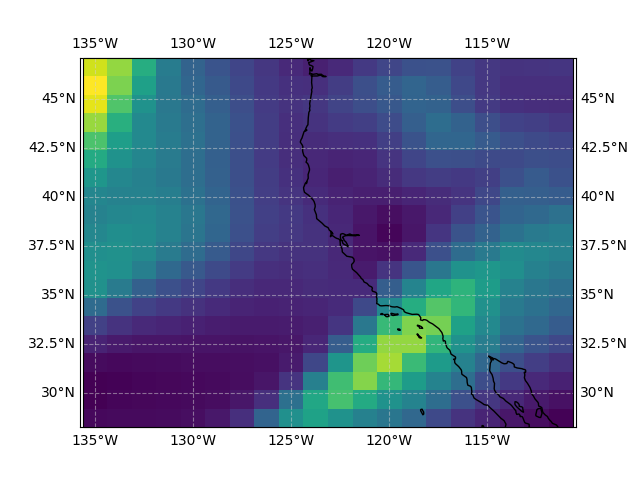

In [7]:
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False

ds.isel(time=0).IVT.plot(label='',
                         add_labels=False,
                         add_colorbar=False,
                         xticks=None,
                         yticks=None)
plt.show()

## Compute AR Category

In [8]:
ds['AR_INDEX'] = xr.apply_ufunc(
    ARUtils.identify_ar_events,  
    ds.IVT,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    # dask='parallelized',
)

In [9]:
ds['AR_DURATION'] = xr.apply_ufunc(
    ARUtils.compute_ar_durations,  
    ds.AR_INDEX,  
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    # dask='parallelized',
)

In [10]:
ds['AR_CATEGORY'] = xr.apply_ufunc(
    ARUtils.compute_ar_category,  
    ds.AR_INDEX,
    ds.AR_DURATION,
    ds.IVT,
    input_core_dims=[["time"],["time"],["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    # dask='parallelized',
)

## Compute AR Category Statistics

In [11]:
ds

<xarray.Dataset> Size: 164MB
Dimensions:      (lat: 20, lon: 20, time: 14600)
Coordinates:
  * lat          (lat) float64 160B 28.74 29.69 30.63 ... 44.76 45.71 46.65
  * lon          (lon) float64 160B 225.0 226.2 227.5 ... 246.2 247.5 248.8
  * time         (time) object 117kB 1980-01-01 00:00:00 ... 1989-12-31 18:00:00
Data variables:
    IVT          (time, lat, lon) float32 23MB 84.35 87.4 87.5 ... 47.94 42.84
    AR_INDEX     (lat, lon, time) float64 47MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    AR_DURATION  (lat, lon, time) int64 47MB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    AR_CATEGORY  (lat, lon, time) float64 47MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [12]:
# convert the time index to datetime64. This is needed to compute probabilities.
ds['time'] = ds.time.values.astype('datetime64[ns]')  

In [13]:
def compute_probability(ar_index, ar_category):

    # computed the number of timesteps containing each AR category.
    # array indices are used to represent each AR category, i.e.
    # cat_counts[1] => category 1, ..., cat_counts[5] => category 5
    cat_counts  = np.array([0, 0, 0, 0, 0, 0])
    total_ar_ts = 0
    for i in range(0, len(ar_index)):
        cat = ar_category[i]
        cat_counts[int(cat)] += 1

    # compute the probability for each category, when AR events are detected, as 
    # well as the overall probability including non-AR events.
    probability_ar = (cat_counts[1:] / sum(cat_counts[1:])) * 100
    probability_overall = (cat_counts / sum(cat_counts)) * 100 # for debugging
    
    return probability_ar

# # test at a single point.
# lat = 38.
# lon = -123.125 + 360 
# ds_cell = ds.sel(lat=lat, lon=lon, method='nearest')

# compute_probability(ds_cell.AR_INDEX.values, ds_cell.AR_CATEGORY.values)

In [14]:
res = xr.apply_ufunc(
    compute_probability,
    ds.AR_INDEX,
    ds.AR_CATEGORY,
    input_core_dims=[["time"],["time"]],
    output_core_dims=[['category']],
    output_dtypes=[float],
    vectorize=True,
    dask='parallelized',
)

# Add the category dimension (from 1 to 5)
res = res.assign_coords(category=np.arange(1, 6))

# add the newly computed probabilty back to the original dataset
ds = ds.assign(AR_PROBABILITY=res)

In [15]:
from itertools import groupby

def compute_degree(arr_ivt, arr_duration, arr_index):

    # Degree is computed as the product of IVT and duration in kg/m
    # this requires a unit conversion of arr_duration from 6-hr to sec timesteps.
    arr_degree = (arr_ivt * arr_duration) * (6 *3600)

    # compute a single degree value for each AR event by summing the
    # previously computed degree for each event in arr_index. Set this
    # value for all timesteps associated with the event.
    arr_event_degree = np.zeros(arr_index.shape)
    #data = sorted(zip(arr_index, arr_degree), key=lambda x: x[0])
    data = zip(arr_index, arr_degree)
    i = 0
    for key, group in groupby(data, lambda x: x[0]):
        # get the values as a list because otherwise we can
        # only access them once, i.e. an iterator empties the
        # array when looping through it.
        dat = [value for _, value in group]
        event_degree_sum = sum(dat)
        arr_event_degree[i: i+len(dat)] = event_degree_sum

        # increment the index by the length of data
        i += len(dat)
        
        #event_degree_sum = sum(value for _, value in group)
        #arr_event_degree[int(key)] = event_degree_sum
        
    return arr_event_degree


# # test at a single point.
# # ----------------------- 
# lat = 38.
# lon = -123.125 + 360 
# ds_cell = ds.sel(lat=lat, lon=lon, method='nearest')

# deg = compute_degree(ds_cell.IVT.values, ds_cell.AR_DURATION.values, ds_cell.AR_INDEX.values)
# fig, ax = plt.subplots()

# ax.scatter(range(1, len(deg)),
#            deg[1:])
# ax.set_xlabel('AR_INDEX')
# ax.set_ylabel('AR_DEGREE')
# plt.show()
# # -----------------------

In [16]:
res = xr.apply_ufunc(
    compute_degree,
    ds.IVT,
    ds.AR_DURATION,
    ds.AR_INDEX,
    input_core_dims=[["time"],["time"],["time"]],
    output_core_dims=[['time']],
    output_dtypes=[float],
    vectorize=True,
    dask='parallelized',
)

# add the newly computed probabilty back to the original dataset
ds = ds.assign(AR_DEGREE=res)

In [17]:
# create a plot to test
lat = 38.
lon = -123.125 + 360 
ds_cell = ds.sel(lat=lat, lon=lon, method='nearest')

In [18]:
# plot AR_DEGREE for cat 5 events
ds_cat5 = ds_cell.where(ds_cell['AR_CATEGORY'] == 5, drop=True)
ds_cat5

<xarray.Dataset> Size: 9kB
Dimensions:         (time: 109, category: 5)
Coordinates:
    lat             float64 8B 38.17
    lon             float64 8B 237.5
  * time            (time) datetime64[ns] 872B 1981-02-15T12:00:00 ... 1988-1...
  * category        (category) int64 40B 1 2 3 4 5
Data variables:
    IVT             (time) float32 436B 293.4 315.6 414.0 ... 980.4 369.2 275.1
    AR_INDEX        (time) float64 872B 45.0 45.0 45.0 ... 280.0 280.0 280.0
    AR_DURATION     (time) float64 872B 12.0 12.0 12.0 12.0 ... 23.0 23.0 23.0
    AR_CATEGORY     (time) float64 872B 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
    AR_PROBABILITY  (category, time) float64 4kB 35.14 35.14 ... 15.57 15.57
    AR_DEGREE       (time) float64 872B 1.709e+09 1.709e+09 ... 7.255e+09

## Plot Computed AR Categories and Degrees

Plot the degree of Category 5 Atmospheric Rivers

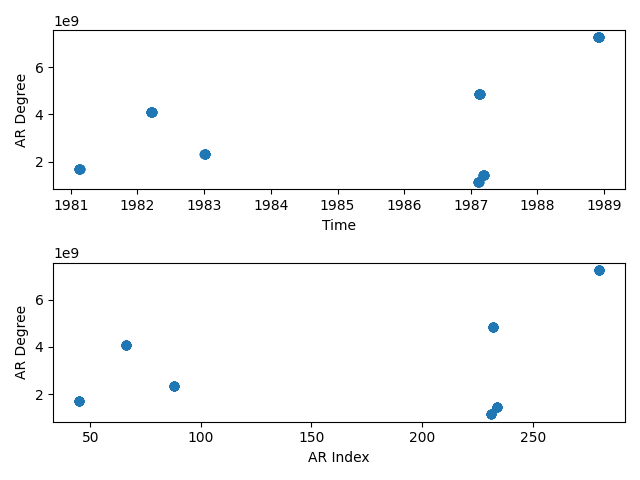

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].scatter(x=ds_cat5.time, y=ds_cat5.AR_DEGREE)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('AR Degree')

axes[1].scatter(x=ds_cat5.AR_INDEX, y=ds_cat5.AR_DEGREE)
axes[1].set_xlabel('AR Index')
axes[1].set_ylabel('AR Degree')


plt.tight_layout()
plt.show()

Spatially plot the probability of Category 5 Atmospheric Rivers

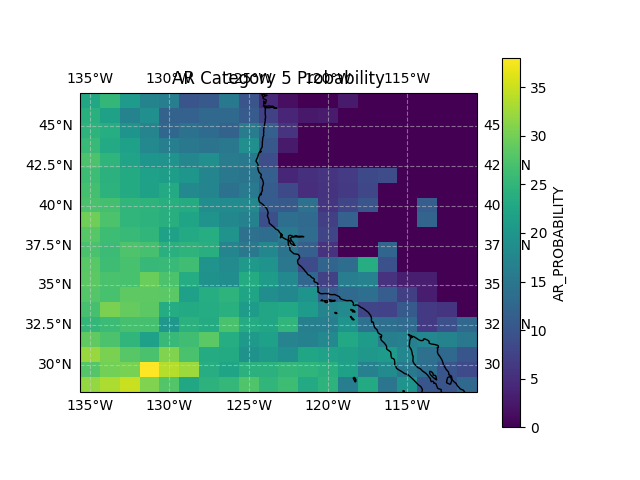

In [20]:
fig, ax = plt.subplots()

ax.axis('off')

ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False

ds.AR_PROBABILITY.sel(category=5).plot()
#ds.AR_PROBABILITY.sel(category=5).plot.contour()

plt.title('AR Category 5 Probability')
plt.show()



AR Category at a singe point in time.

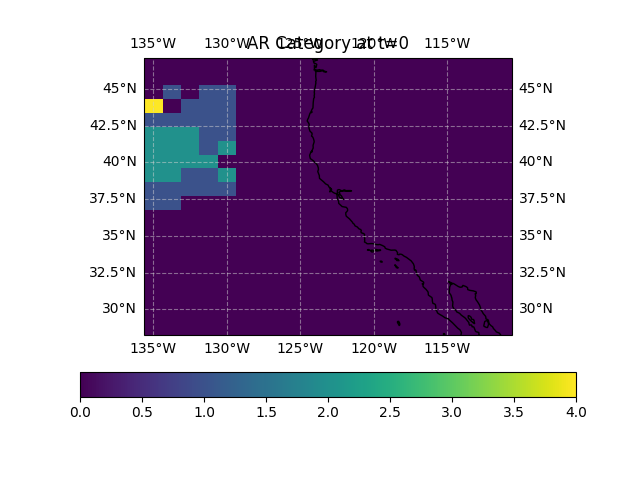

In [22]:
fig, ax = plt.subplots()
ax.axis('off')

ax = plt.axes(projection=ccrs.PlateCarree())

#add coastlines
ax.add_feature(cfeature.COASTLINE)

#add lat lon grids
gl = ax.gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False

ds.isel(time=0).AR_CATEGORY.plot(label='',
                                 add_labels=False,
                                 add_colorbar=True,
                                 xticks=None,
                                 yticks=None,
                                 cbar_kwargs={"location": "bottom", "pad":0.1})

plt.title('AR Category at t=0')
plt.show()

Mean AR category through the record of data.

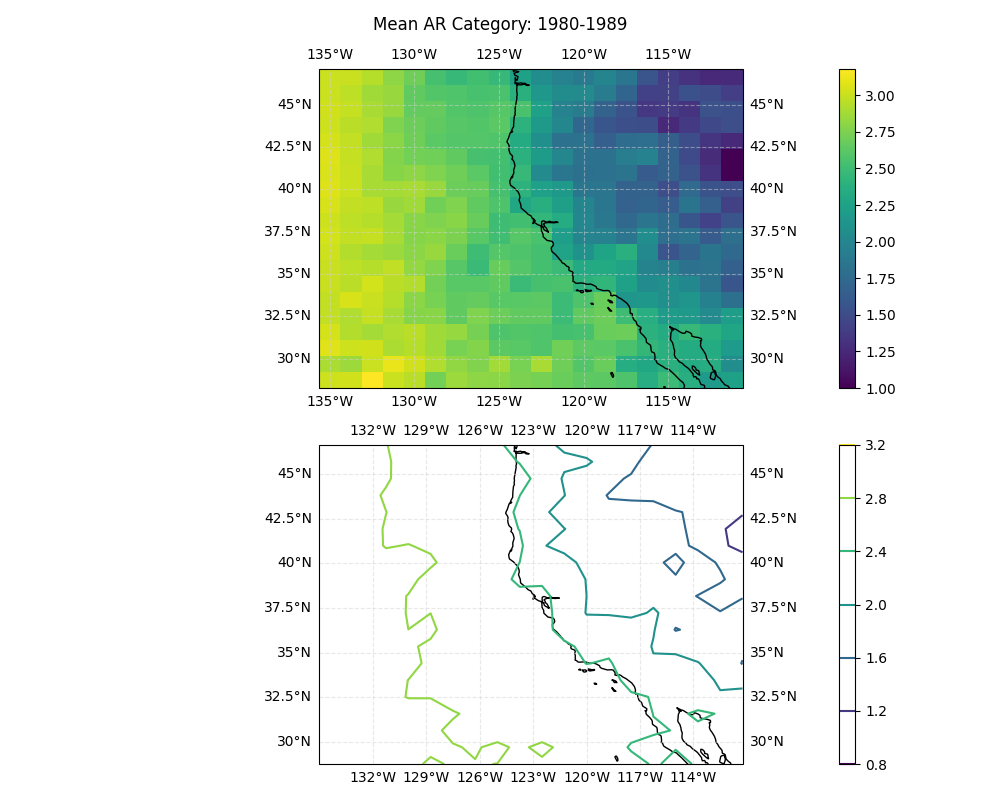

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=1,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,8))
#ax[0].axis('off')
#ax[1].axis('off')

ax[0].coastlines();
ax[1].coastlines();

#add lat lon grids
ax[0].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');
ax[1].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');


ds.where(ds.AR_CATEGORY > 0).AR_CATEGORY.mean(dim='time').plot(label='',
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[0])

ds.where(ds.AR_CATEGORY > 0).AR_CATEGORY.mean(dim='time').plot.contour(
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[1])

fig.suptitle('Mean AR Category: 1980-1989')
plt.tight_layout()
plt.show()

Sum of AR category through the record of data.

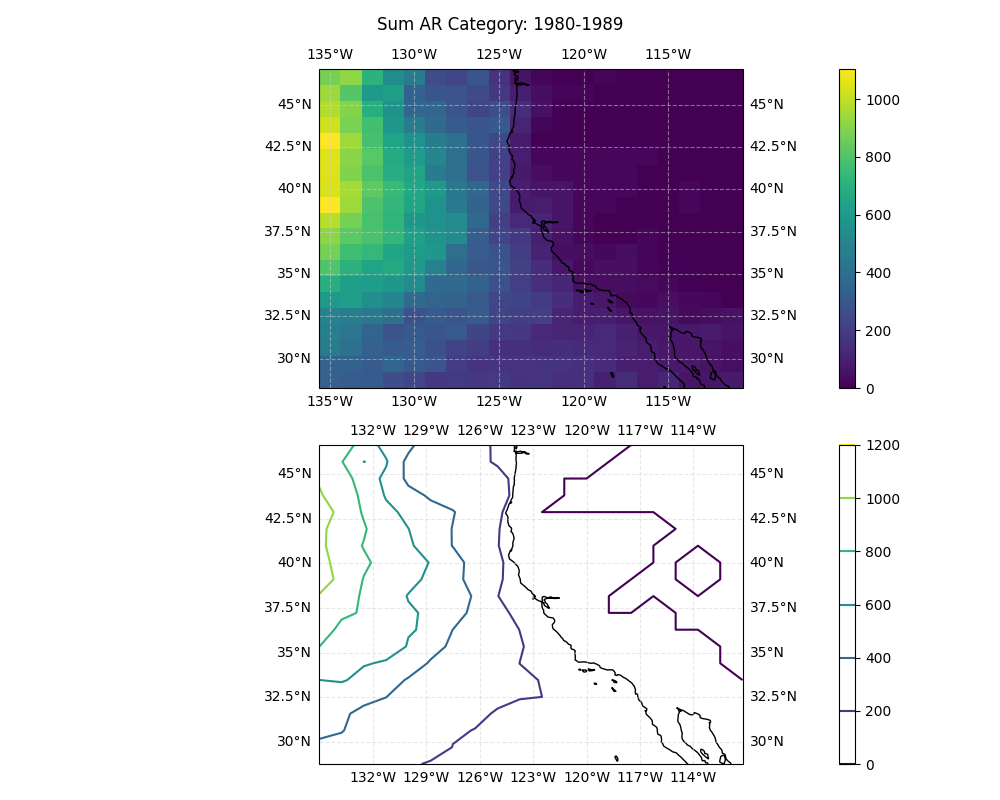

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,8))

ax[0].coastlines();
ax[1].coastlines();

#add lat lon grids
ax[0].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');
ax[1].gridlines(draw_labels=True, color='lightgrey', alpha=0.5, linestyle='--');


(ds.where(ds.AR_CATEGORY == 5).AR_CATEGORY.sum(dim='time') / 5).plot(label='',
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[0])
(ds.where(ds.AR_CATEGORY == 5).AR_CATEGORY.sum(dim='time') / 5).plot.contour(
                                                               add_labels=False,
                                                               add_colorbar=True,
                                                               cbar_kwargs={"location": "right", "pad":0.1},
                                                               ax=ax[1])

fig.suptitle('Sum AR Category: 1980-1989')
plt.tight_layout()
plt.show()